In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import healpy as hp
import numpy as np
import h5py, os

from astropy.io import fits
from functools import reduce

from msfm.utils import files
from msfm.utils.files import load_pixel_file
from msfm.utils.maps import map_to_data_vec, data_vec_to_map

In this notebook, the `.h5` file containing the correct pixel indices for all of the masks used in the project are generated. Here, the mask from Section II.D in https://arxiv.org/pdf/2105.13546 is used for both weak lensing and galaxy clustering and all redshift bins.

Based off [KiDS_1000_index_file.ipynb](https://cosmo-gitlab.phys.ethz.ch/jafluri/arne_handover/-/blob/main/carpet/notebooks/KiDS_1000_index_file.ipynb) by Janis Fluri.

### global constants

In [3]:
conf = files.load_config( "../../configs/v9/linear_bias.yaml")
n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]
n_side_down = conf["analysis"]["n_side_down"]
metacal_z_bins = conf["survey"]["metacal"]["z_bins"]
maglim_z_bins = conf["survey"]["maglim"]["z_bins"]

out_file = f"../../data/DESY3_pixels_v11_fiducial_{n_side}.h5"

# these rotation angles were found by trial and error and don't preserve the number and arrangement of pixels
y_rot_angle = -0.125
z_rot_angle = -1.22
pix_rotator = hp.Rotator(rot=(0, -y_rot_angle, z_rot_angle), eulertype="Y", deg=False)

# fiducial mask

### original

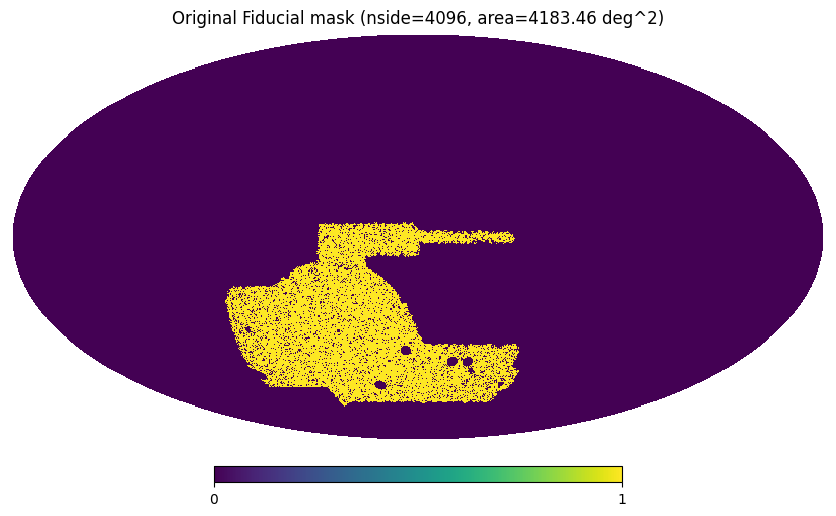

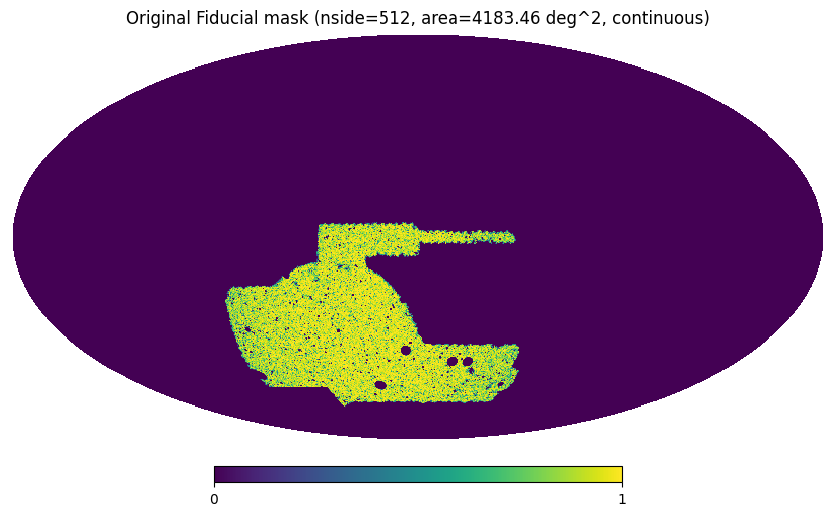

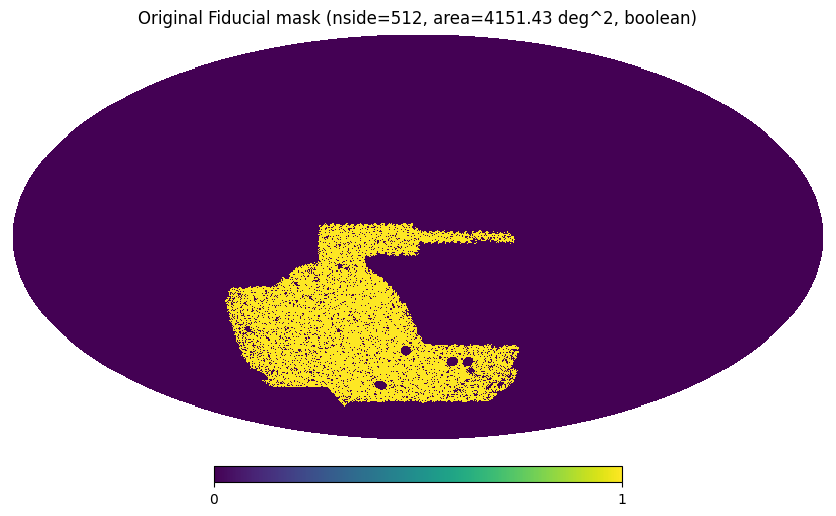

In [4]:
# from https://cdcvs.fnal.gov/redmine/projects/des-lss/wiki/Y3LSS-lens-sample-mask
# maglim_mask_dir = f"/Users/arne/data/DESY3/masks/y3_gold_2.2.1_RING_joint_redmagic_v0.5.1_wide_maglim_v2.2_mask.fits.gz"
maglim_mask_dir = f"~/multiprobe-simulation-forward-model/data/y3_gold_2.2.1_RING_joint_redmagic_v0.5.1_wide_maglim_v2.2_mask.fits.gz"

data, header = fits.getdata(maglim_mask_dir, header = True)
mask_inds = data["HPIX"]

fiducial_mask = np.zeros(hp.nside2npix(4096))
fiducial_mask[mask_inds] = 1
area = len(mask_inds) * hp.nside2pixarea(4096, degrees=True)
hp.mollview(fiducial_mask, title=f"Original Fiducial mask (nside=4096, area={area:.2f} deg^2)")

# determines when a lower resolution pixel is kept when it is only partially filled
threshold = 0.72

mask_downsampled = hp.ud_grade(fiducial_mask.copy(), nside_out=n_side, pess=False)
hp.mollview(mask_downsampled, title=f"Original Fiducial mask (nside=512, area={area:.2f} deg^2, continuous)")
mask_downsampled[mask_downsampled < threshold] = 0
mask_downsampled[mask_downsampled >= threshold] = 1
area = np.sum(mask_downsampled) * hp.nside2pixarea(n_side, degrees=True)
hp.mollview(mask_downsampled, title=f"Original Fiducial mask (nside=512, area={area:.2f} deg^2, boolean)")

### rotated

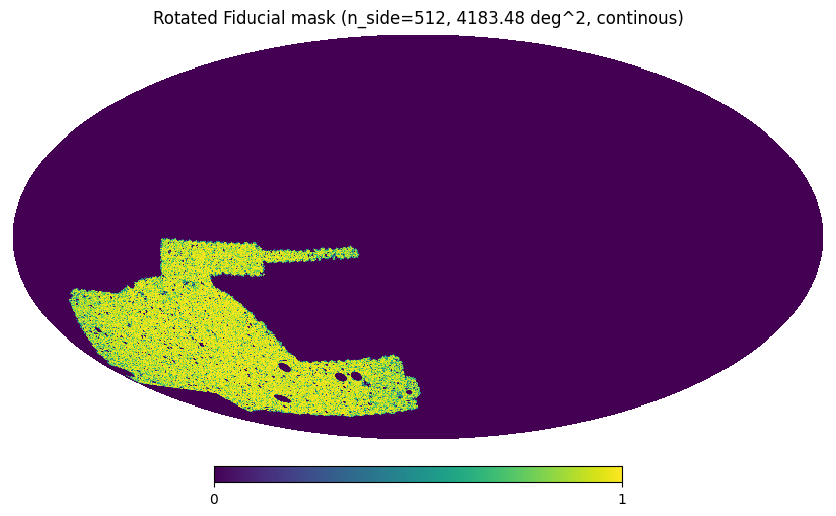

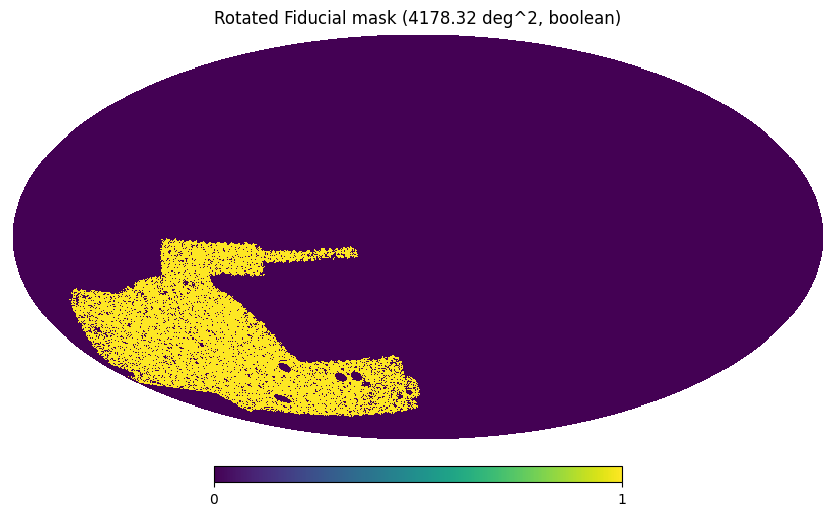

In [5]:
# rotate at the highest possible resolution
rot_mask = pix_rotator.rotate_map_pixel(fiducial_mask)
rot_mask = hp.ud_grade(rot_mask, nside_out=n_side, pess=False)
area = np.sum(rot_mask) * hp.nside2pixarea(n_side, degrees=True)
hp.mollview(rot_mask, title=f"Rotated Fiducial mask (n_side=512, {area:.2f} deg^2, continous)")

mask = np.zeros_like(rot_mask, dtype=bool)
mask[rot_mask < threshold] = False
mask[rot_mask >= threshold] = True
area = np.sum(mask) * hp.nside2pixarea(n_side, degrees=True)
hp.mollview(mask, title=f"Rotated Fiducial mask ({area:.2f} deg^2, boolean)")

# Transformations

### HEALPix Symmetry transformations

In [6]:
# mirror (up down)
def mirror_pix(pix, nside=n_side, lr=False):
    theta, phi = hp.pix2ang(ipix=pix, nside=n_side)
    if lr:
        phi = 2*np.pi - phi
    else:
        theta = np.pi - theta
    new_pix = hp.ang2pix(theta=theta, phi=phi, nside=nside)

    # make sure that no pixel appears twice that should not
    assert len(set(new_pix)) == len(set(pix))

    return new_pix

# 90 degree rotations
def rotate_pix(pix, n_rot=1, nside=n_side):
    theta, phi = hp.pix2ang(ipix=pix, nside=nside)
    phi = (phi + n_rot*np.pi/2) % (2*np.pi)
    new_pix = hp.ang2pix(theta=theta, phi=phi, nside=nside)

    # make sure that no pixel appears twice that should not
    assert len(set(new_pix)) == len(set(pix))
    
    return new_pix

# our mask

### symmetry transforms (all patches for all bins)

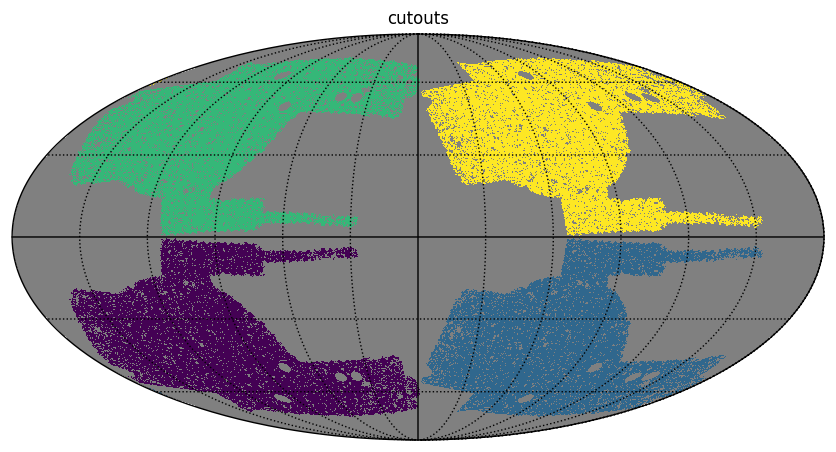

In [7]:
# map -> pixel indices
patch_0 = np.arange(n_pix)[mask]

# perform symmetry transformations
patch_1 = rotate_pix(patch_0, n_rot=2)
patch_2 = mirror_pix(patch_0, lr=False)
patch_3 = mirror_pix(patch_0, lr=False)
patch_3 = rotate_pix(patch_3, n_rot=2)

# all patches have the same size
assert len(patch_0) == len(patch_1) == len(patch_2) == len(patch_3)
# no index occurs more than once
assert reduce(np.intersect1d, ([patch_0, patch_1, patch_2, patch_3])).size == 0

patches = np.stack([patch_0, patch_1, patch_2, patch_3], axis=0)

# plot the total mask
full_mask = np.full(n_pix, hp.UNSEEN)
full_mask[patch_0] = 0
full_mask[patch_1] = 1
full_mask[patch_2] = 2
full_mask[patch_3] = 3
hp.mollview(full_mask, title="cutouts", cbar=False)
hp.graticule()

### metacal

In [8]:
# save the patches
with h5py.File(out_file, "a") as f:
    base_grp = f.create_group("metacal/")
    base_grp.attrs["info"] = "This group contains the datasets related to the Metacalibration galaxy sample. "

    dset = f.create_dataset("metacal/gamma_2_sign", data=[1, 1, -1, -1], dtype="i")
    dset.attrs["info"] = "This dataset contains the factor by which the gamma_2 component of the shear maps has to " \
                         "be multiplied. For patches that contain mirroring, gamma_2 needs to be multiplied by " \
                         "minus one. The rotations by 90 degrees are fine."

    for z_bin in metacal_z_bins:
        dset = f.create_dataset(f"metacal/patches/{z_bin}", data=patches, dtype="i")
        dset.attrs["info"] = f"This dataset contains all pixel ids for a map with nside {n_side} in RING ordering, " \
                             "to cut out 4 DES Y3 data patches simulataneously. " \
                             "The shape is (N_patches, N_pix), the first patch is the original (but rotated) one. " \
                             f"Data is for tomo bin: {z_bin}"

### maglim

In [9]:
# save the patches
with h5py.File(out_file, "a") as f:
    base_grp = f.create_group("maglim/")
    base_grp.attrs["info"] = "This group contains the datasets related to the Maglim galaxy sample. "

    for z_bin in maglim_z_bins:
        dset = f.create_dataset(f"maglim/patches/{z_bin}", data=patches, dtype="i")
        dset.attrs["info"] = f"This dataset contains all pixel ids for a map with nside {n_side} in RING ordering, " \
                             "to cut out 4 DES Y3 data patches simulataneously. " \
                             "The shape is (N_patches, N_pix), the first patch is the original (but rotated) one. " \
                             f"Data is for tomo bin: {z_bin}"

### Extend the indices, i.e. padding for network

Non padded: 318616 pixels
Padded:     458752 pixels


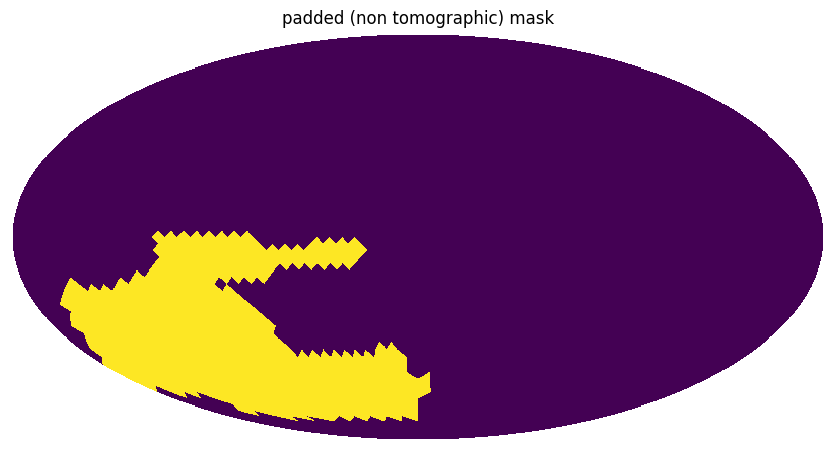

In [10]:
# minimal possible nside for the network to downsample
padded_mask = hp.ud_grade(mask, nside_out=n_side_down, order_in='RING', order_out='RING')
padded_mask = hp.ud_grade(padded_mask, nside_out=n_side, order_in='RING', order_out='RING')
hp.mollview(padded_mask, title="padded (non tomographic) mask", cbar=False)

print(f"Non padded: {np.sum(mask)} pixels")
print(f"Padded:     {np.sum(padded_mask)} pixels")
assert np.sum(padded_mask) > np.sum(mask)

In [11]:
# get the pixel in nest ordering (from the mask on map level)
padded_mask_nest = hp.reorder(padded_mask, r2n=True)
data_vec_pix = np.arange(n_pix)[padded_mask_nest]

In [12]:
# save the indices
with h5py.File(out_file, "a") as f:
    dset = f.create_dataset("data_vec", dtype="i", data=data_vec_pix)
    dset.attrs["info"] = "This dataset contains all relevant pixels from the original rotated " \
                         "DES Y3 patch in NEST ordering, such that it can be downsampled to " \
                         f"an nside of {n_side_down} without the need of additional padding."

### corresponding pix

Now comes the tricky part:

The idea for a fast and efficient cut out procedure of the simulated maps is that one can generate data vectors that only consist of zeros (including the padding) and then fill in the necessary pixels. To make this possible, we need to know the correspondence of the pixels inside the data vector (NEST ordering) with pixels in RING ordering of the full sky map.

In [13]:
# dict for fast look up
data_vec_pix_lookup = {}
for i, pix_id in enumerate(data_vec_pix):
    data_vec_pix_lookup.update({pix_id: i})

In [14]:
# the base patch
nest_patch_0 = hp.ring2nest(n_side, patch_0)

# now we need to get the index in non_tomo_pixels_nest_ext that corresponds to the pix id
corresponding_pix = []
for pix_id in nest_patch_0:
    corresponding_pix.append(data_vec_pix_lookup[pix_id])
corresponding_pix = np.array(corresponding_pix)

### metacal

In [15]:
# save the patches
with h5py.File(out_file, "a") as f:
    grp = f.create_group("metacal/patch_to_data_vec")
    for z_bin in metacal_z_bins:
        dset = grp.create_dataset(z_bin, dtype="i", data=corresponding_pix)
        dset.attrs["info"] = "This dataset contains the pixel ids that map the patches in RING " \
                             "ordering to the data vector in NEST ordering. " \
                             f"Data is for tomo bin: {z_bin}"

### maglim

In [16]:
# save the patches
with h5py.File(out_file, "a") as f:
    grp = f.create_group("maglim/patch_to_data_vec")
    for z_bin in maglim_z_bins:
        dset = grp.create_dataset(z_bin, dtype="i", data=corresponding_pix)
        dset.attrs["info"] = "This dataset contains the pixel ids that map the patches in RING " \
                             "ordering to the data vector in NEST ordering. " \
                             f"Data is for tomo bin: {z_bin}"

### Survey systematics maps

In [17]:
# full healpy map
tomo_sys_map = []
# same shape as the masked data vectors, so that they can be multiplied componentwise
tomo_sys_dv = []

for i in range(len(maglim_z_bins)):
# for i in range(1):
    # at NERSC here:
    # /global/cfs/cdirs/des/monroy/systematics_analysis/pca_tests/maglim_v2.2_new_zbinning_jointmask/pca_107_maps/jointmask_w_maps_nbins1d_10_2.0sig_pca_maps_107_50_cut
    map_file = f"/Users/arne/data/DESY3/systematics_analysis/pca_tests/maglim_v2.2_new_zbinning_jointmask/pca_107_maps/jointmask_w_maps_nbins1d_10_2.0sig_pca_maps_107_50_cut/w_map_bin{i}_nside4096_nbins1d_10_2sig_v2.0.fits.gz"
    data, header = fits.getdata(map_file, header = True)

    # the default value is one (not zero)
    sys_map = np.full(hp.nside2npix(4096), 1.0)
    sys_map[data["HPIX"]] = data["VALUE"]

    # rotate
    rot_sys_map = pix_rotator.rotate_map_pixel(sys_map)

    # downsample, power = 0 means a straight forward mean
    rot_sys_map = hp.ud_grade(rot_sys_map, nside_out=n_side, power=0)

    # mask
    rot_sys_map *= mask

    # full map
    # hp.mollview(rot_sys_map, title=f"Rotated maglim survey systematics map, bin{i+1}")
    tomo_sys_map.append(rot_sys_map[patch_0])

    hp_map = np.zeros(n_pix)
    hp_map[patch_0] = tomo_sys_map[-1]
    hp.mollview(hp_map, title=f"survey systematics map, bin {i}", nest=False)

    # data vector
    maglim_cutout_pix = np.arange(n_pix)[mask]
    sys_dv = map_to_data_vec(rot_sys_map, len(data_vec_pix), corresponding_pix, maglim_cutout_pix)
    tomo_sys_dv.append(sys_dv)

    hp_map = np.full(n_pix, hp.UNSEEN)
    hp_map[data_vec_pix] = sys_dv
    hp.mollview(hp_map, title=f"survey systematics datavector, bin {i}", nest=True)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/arne/data/DESY3/systematics_analysis/pca_tests/maglim_v2.2_new_zbinning_jointmask/pca_107_maps/jointmask_w_maps_nbins1d_10_2.0sig_pca_maps_107_50_cut/w_map_bin0_nside4096_nbins1d_10_2sig_v2.0.fits.gz'

In [ ]:
# potentially only consider the first four maglim bins
tomo_sys_dv = tomo_sys_dv[:len(maglim_z_bins)]

# save the patches
with h5py.File(out_file, "a") as f:
        for sys_map, sys_dv, z_bin in zip(tomo_sys_map, tomo_sys_dv, maglim_z_bins):
            # map
            dset = f.create_dataset(f"maglim/systematics/map/{z_bin}", data=sys_map, dtype="f4")
            dset.attrs["info"] = f"This dataset contains the rotated maglim systematics maps in RING ordering format for bin {i}"

            # data vector
            dset = f.create_dataset(f"maglim/systematics/data_vector/{z_bin}", data=sys_dv, dtype="f4")
            dset.attrs["info"] = f"This dataset contains the rotated maglim systematics maps in datavector format (NEST ordering) for bin {i}"

# inspect the file

In [ ]:
with h5py.File(out_file, "r") as f:
    ic(f.keys())

    ic(f["metacal"].keys())
    ic(f["maglim"].keys())
    ic(f["data_vec"][:].shape)

    ic(f["metacal/patches"].keys())
    ic(f["maglim/patches"].keys())


In [ ]:
data_vec_pix, patches_pix_dict, corresponding_pix_dict, _ = load_pixel_file(conf)

metacal_tomo_patches_pix = patches_pix_dict["metacal"]
metacal_tomo_corresponding_pix = corresponding_pix_dict["metacal"]

maglim_tomo_patches_pix = patches_pix_dict["maglim"]
maglim_tomo_corresponding_pix = corresponding_pix_dict["maglim"]

## testing

In [ ]:
# we start be generating a random map
np.random.seed(11)
Cl = np.arange(1, 1001)**-3.
example_map = hp.synfast(cls=Cl, nside=n_side)

z_min = np.min(example_map)
z_max = np.max(example_map)

# plot
hp.mollview(example_map, min=z_min, max=z_max)

### cut outs

In [ ]:
i_z = 0

for patch_id in range(4):
    base_patch = metacal_tomo_patches_pix[i_z][0]
    current_patch = metacal_tomo_patches_pix[i_z][patch_id]

    m_plot = np.full(n_pix, hp.UNSEEN)
    m_plot[base_patch] = example_map[current_patch]
    hp.mollview(m_plot, min=z_min, max=z_max, title=f"Metacal: patch {patch_id}")

    # Maglim
    base_patch = maglim_tomo_patches_pix[i_z][0]
    current_patch = maglim_tomo_patches_pix[i_z][patch_id]

    m_plot = np.full(n_pix, hp.UNSEEN)
    m_plot[base_patch] = example_map[current_patch]
    hp.mollview(m_plot, min=z_min, max=z_max, title=f"Maglim: patch {patch_id}")

### data vectors

In [ ]:
i_z = 0

for patch_id in range(4):
    # Metacal
    cutout_pix = metacal_tomo_patches_pix[i_z][patch_id]
    corresponding_pix = metacal_tomo_corresponding_pix[i_z]

    data_vec = map_to_data_vec(example_map, len(data_vec_pix), corresponding_pix, cutout_pix)

    m_plot = np.full(n_pix, hp.UNSEEN)
    m_plot[data_vec_pix] = data_vec
    hp.mollview(m_plot, min=z_min, max=z_max, title=f"Metacal: bin {z_bin}, patch {patch_id}, len(cutout_pix) = {len(cutout_pix)}", nest=True)

    # Maglim
    cutout_pix = maglim_tomo_patches_pix[i_z][patch_id]
    corresponding_pix = maglim_tomo_corresponding_pix[i_z]

    data_vec = map_to_data_vec(example_map, len(data_vec_pix), corresponding_pix, cutout_pix)

    m_plot = np.full(n_pix, hp.UNSEEN)
    m_plot[data_vec_pix] = data_vec
    hp.mollview(m_plot, min=z_min, max=z_max, title=f"Maglim: patch {patch_id}, len(cutout_pix) = {len(cutout_pix)}", nest=True)